<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/DualGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In dualGAN, two types of feedback signals are included for discrimination, The membership score which evaluates the likelihood of the output belonging to the approapriate distribution, and the reconstruction error that measures the disparity between the reconstructed
images and the original.

![alt text](https://i.ibb.co/nbshJW4/DualGAN.png)

In [1]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

!mkdir images
!mkdir saved_model

Using TensorFlow backend.


mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘saved_model’: File exists


In [0]:

class DUALGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_dim = self.img_rows*self.img_cols

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.D_A = self.build_discriminator()
        self.D_A.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])
        self.D_B = self.build_discriminator()
        self.D_B.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.G_AB = self.build_generator()
        self.G_BA = self.build_generator()

        # For the combined model we will only train the generators
        self.D_A.trainable = False
        self.D_B.trainable = False

        # The generator takes images from their respective domains as inputs
        imgs_A = Input(shape=(self.img_dim,))
        imgs_B = Input(shape=(self.img_dim,))

        # Generators translates the images to the opposite domain
        fake_B = self.G_AB(imgs_A)
        fake_A = self.G_BA(imgs_B)

        # The discriminators determines validity of translated images
        valid_A = self.D_A(fake_A)
        valid_B = self.D_B(fake_B)

        # Generators translate the images back to their original domain
        recov_A = self.G_BA(fake_B)
        recov_B = self.G_AB(fake_A)

        # The combined model  (stacked generators and discriminators)
        self.combined = Model(inputs=[imgs_A, imgs_B], outputs=[valid_A, valid_B, recov_A, recov_B])
        self.combined.compile(loss=[self.wasserstein_loss, self.wasserstein_loss, 'mae', 'mae'],
                            optimizer=optimizer,
                            loss_weights=[1, 1, 100, 100])

In [0]:

def build_generator(self):

    X = Input(shape=(self.img_dim,))

    model = Sequential()
    model.add(Dense(256, input_dim=self.img_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.4))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.4))
    model.add(Dense(self.img_dim, activation='tanh'))

    X_translated = model(X)

    return Model(X, X_translated)


In [0]:

def build_discriminator(self):

    img = Input(shape=(self.img_dim,))

    model = Sequential()
    model.add(Dense(512, input_dim=self.img_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1))

    validity = model(img)

    return Model(img, validity)


In [0]:

def sample_generator_input(self, X, batch_size):
    # Sample random batch of images from X
    idx = np.random.randint(0, X.shape[0], batch_size)
    return X[idx]

def wasserstein_loss(self, y_true, y_pred):
    return K.mean(y_true * y_pred)


In [0]:

def train(self, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    # Domain A and B (rotated)
    X_A = X_train[:int(X_train.shape[0]/2)]
    X_B = scipy.ndimage.interpolation.rotate(X_train[int(X_train.shape[0]/2):], 90, axes=(1, 2))

    X_A = X_A.reshape(X_A.shape[0], self.img_dim)
    X_B = X_B.reshape(X_B.shape[0], self.img_dim)

    clip_value = 0.01
    n_critic = 4

    # Adversarial ground truths
    valid = -np.ones((batch_size, 1))
    fake = np.ones((batch_size, 1))

    for epoch in range(epochs):

        # Train the discriminator for n_critic iterations
        for _ in range(n_critic):

            # ----------------------
            #  Train Discriminators
            # ----------------------

            # Sample generator inputs
            imgs_A = self.sample_generator_input(X_A, batch_size)
            imgs_B = self.sample_generator_input(X_B, batch_size)

            # Translate images to their opposite domain
            fake_B = self.G_AB.predict(imgs_A)
            fake_A = self.G_BA.predict(imgs_B)

            # Train the discriminators
            D_A_loss_real = self.D_A.train_on_batch(imgs_A, valid)
            D_A_loss_fake = self.D_A.train_on_batch(fake_A, fake)

            D_B_loss_real = self.D_B.train_on_batch(imgs_B, valid)
            D_B_loss_fake = self.D_B.train_on_batch(fake_B, fake)

            D_A_loss = 0.5 * np.add(D_A_loss_real, D_A_loss_fake)
            D_B_loss = 0.5 * np.add(D_B_loss_real, D_B_loss_fake)

            # Clip discriminator weights
            for d in [self.D_A, self.D_B]:
                for l in d.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                    l.set_weights(weights)

        # ------------------
        #  Train Generators
        # ------------------

        # Train the generators
        g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, valid, imgs_A, imgs_B])

        # Plot the progress
        print ("%d [D1 loss: %f] [D2 loss: %f] [G loss: %f]" \
            % (epoch, D_A_loss[0], D_B_loss[0], g_loss[0]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            self.save_imgs(epoch, X_A, X_B)


In [0]:

def save_imgs(self, epoch, X_A, X_B):
    r, c = 4, 4

    # Sample generator inputs
    imgs_A = self.sample_generator_input(X_A, c)
    imgs_B = self.sample_generator_input(X_B, c)

    # Images translated to their opposite domain
    fake_B = self.G_AB.predict(imgs_A)
    fake_A = self.G_BA.predict(imgs_B)

    gen_imgs = np.concatenate([imgs_A, fake_B, imgs_B, fake_A])
    gen_imgs = gen_imgs.reshape((r, c, self.img_rows, self.img_cols, 1))

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[i, j, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()


In [8]:
DUALGAN.build_generator =  build_generator
DUALGAN.build_discriminator =  build_discriminator
DUALGAN.train =  train
DUALGAN.wasserstein_loss =  wasserstein_loss
DUALGAN.sample_generator_input =  sample_generator_input
DUALGAN.save_imgs =  save_imgs

del build_generator,build_discriminator,train,wasserstein_loss,save_imgs

gan = DUALGAN()
gan.train(epochs=30000, batch_size=32, sample_interval=200)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D1 loss: 0.000079] [D2 loss: 0.000084] [G loss: 195.064240]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D1 loss: 0.000093] [D2 loss: 0.000092] [G loss: 193.858597]
2 [D1 loss: 0.000094] [D2 loss: 0.000094] [G loss: 194.888168]
3 [D1 loss: 0.000094] [D2 loss: 0.000094] [G loss: 194.059402]
4 [D1 loss: 0.000092] [D2 loss: 0.000092] [G loss: 194.628784]
5 [D1 loss: 0.000088] [D2 loss: 0.000089] [G loss: 193.155090]
6 [D1 loss: 0.000085] [D2 loss: 0.000086] [G loss: 193.084198]
7 [D1 loss: 0.000081] [D2 loss: 0.000084] [G loss: 193.056213]
8 [D1 loss: 0.000079] [D2 loss: 0.000080] [G loss: 192.425354]
9 [D1 loss: 0.000076] [D2 loss: 0.000078] [G loss: 191.627426]
10 [D1 loss: 0.000072] [D2 loss: 0.000074] [G loss: 190.833740]
11 [D1 loss: 0.000071] [D2 loss: 0.000072] [G loss: 191.216232]
12 [D1 loss: 0.000069] [D2 loss: 0.000070] [G loss: 190.441925]
13 [D1 loss: 0.000067] [D2 loss: 0.000068] [G loss: 190.704849]
14 [D1 loss: 0.000065] [D2 loss: 0.000067] [G loss: 189.841949]
15 [D1 loss: 0.000063] [D2 loss: 0.000066] [G loss: 188.097717]
16 [D1 loss: 0.000063] [D2 loss: 0.000065] [G los

KeyboardInterrupt: ignored

images/mnist_0.png     images/mnist_2000.png  images/mnist_3000.png
images/mnist_1000.png  images/mnist_200.png   images/mnist_3200.png
images/mnist_1200.png  images/mnist_2200.png  images/mnist_3400.png
images/mnist_1400.png  images/mnist_2400.png  images/mnist_400.png
images/mnist_1600.png  images/mnist_2600.png  images/mnist_600.png
images/mnist_1800.png  images/mnist_2800.png  images/mnist_800.png


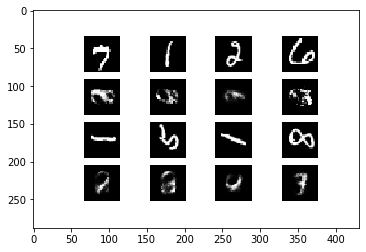

In [12]:
!ls images/*
img = plt.imread("images/mnist_3400.png")
plt.imshow(img)